### cosine similarity + NormalScaler

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
with open(user_profiles_path, 'r') as file:
    user_profiles_content = (json.loads(line) for line in file)
    user_profiles_df = pd.DataFrame(user_profiles_content)

with open(routes_path, 'r') as file:
    routes_content = [json.loads(line) for line in file if line.strip()]

routes_df = pd.DataFrame(routes_content)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = MinMaxScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=10):
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['average_distances']}<br>" \
                    f"Average Condition Value: {user_data['average_condition_value']}"

    map_obj = folium.Map(location=user_location, zoom_start=12)
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]  # Wijs een kleur toe aan elke route
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Average Altitude Change: {route_data['altitude_change']}<br>" \
                        f"Average Distance: {route_data['distance']}<br>" \
                        f"Average Condition Value: {route_data['average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj)  # Toon de kaart direct


    return recommended_routes


# Stap 6: Test de functie voor een specifieke gebruiker

# sample_user_id = 3545637
sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)


,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,userId,average_condition_value,mean_altitude,mean_latitude,mean_longitude,distance_to_user,similarity_score
4352,"[55.44989445246756, 55.44987626373768, 55.4498...","[11.562541304156184, 11.562534598633647, 11.56...","[35.8, 42.6, 35.6, 35.4, 36.0, 36.0, 35.2, 35....",run,331799033,"[70, 70, 71, 72, 75, 79, 80, 81, 82, 85, 86, 8...","[1398800962, 1398800965, 1398800969, 139880097...","[6.408, 6.408, 9.252, 10.08, 5.472, 10.296, 12...",0.047296,0.002616,907015,0.079104,0.065197,55.451421,11.567167,4.849071,0.999958
1073,"[55.35336778499186, 55.3534072637558, 55.35348...","[11.374538401141763, 11.374544184654951, 11.37...","[47.0, 47.2, 47.2, 46.0, 45.6, 45.2, 44.6, 44....",run,432098315,"[103, 107, 116, 123, 128, 131, 134, 138, 142, ...","[1414857346, 1414857348, 1414857351, 141485735...","[5.6772, 5.7132, 7.0236, 9.234, 11.07, 12.4884...",0.042830,0.004865,804068,0.078257,0.065508,55.357093,11.386502,10.751625,0.999900
1072,"[55.35341262817383, 55.35347146913409, 55.3535...","[11.374501269310713, 11.374529683962464, 11.37...","[33.6, 33.4, 33.2, 33.0, 33.0, 32.8, 32.8, 32....",run,432098322,"[118, 118, 118, 123, 127, 130, 133, 137, 138, ...","[1414861864, 1414861867, 1414861870, 141486187...","[1.8468, 5.3064, 7.4268, 8.3448, 9.4824, 10.48...",0.042737,0.003924,804068,0.078257,0.065530,55.357048,11.386290,10.765289,0.999900
1059,"[55.394607838243246, 55.394567772746086, 55.39...","[11.319797029718757, 11.31985486485064, 11.319...","[52.8, 52.6, 52.4, 52.0, 51.8, 51.4, 51.2, 51....",run,538852045,"[68, 73, 82, 91, 99, 104, 108, 112, 113, 116, ...","[1433816447, 1433816450, 1433816454, 143381645...","[3.0564, 5.436, 6.9588, 8.5356, 10.0656, 9.871...",0.052080,0.004238,804068,0.078257,0.066588,55.393643,11.334497,11.956276,0.999888
1057,"[55.394615549594164, 55.394615130499005, 55.39...","[11.319836340844631, 11.319876741617918, 11.31...","[51.2, 51.2, 51.0, 51.0, 50.8, 50.6, 50.6, 50....",run,623842455,"[79, 83, 86, 92, 97, 100, 104, 107, 112, 115, ...","[1445907880, 1445907883, 1445907886, 144590788...","[2.4768, 3.1464, 5.2272, 6.6996, 8.55, 10.0512...",0.041570,0.004918,804068,0.078257,0.065883,55.398475,11.325751,12.391157,0.999887
1054,"[55.394604317843914, 55.3945963550359, 55.3945...","[11.319726118817925, 11.319757383316755, 11.31...","[54.2, 54.0, 53.8, 53.6, 53.2, 53.0, 52.8, 52....",run,637053714,"[88, 90, 94, 98, 101, 105, 108, 109, 110, 111,...","[1448499204, 1448499206, 1448499209, 144849921...","[3.0708, 2.8944, 5.1624, 7.1892, 8.3844, 10.10...",0.041630,0.004865,804068,0.078257,0.065962,55.398489,11.325702,12.393925,0.999887
1058,"[55.39458227343857, 55.394569197669625, 55.394...","[11.319661494344473, 11.319689489901066, 11.31...","[39.2, 39.0, 39.2, 39.2, 39.2, 39.2, 39.4, 39....",run,541330319,"[74, 74, 77, 80, 81, 86, 90, 93, 97, 100, 104,...","[1434143724, 1434143725, 1434143727, 143414372...","[3.5748, 4.4964, 7.4592, 8.4168, 8.7264, 9.655...",0.021932,0.002720,804068,0.078257,0.066459,55.396961,11.324281,12.513330,0.999887
1023,"[55.52696336992085, 55.52696471102536, 55.5269...","[11.498612193390727, 11.498662484809756, 11.49...","[31.2, 31.2, 31.0, 31.0, 31.0, 31.0, 31.0, 31....",run,526392485,"[80, 83, 87, 90, 93, 96, 97, 101, 104, 108, 11...","[1432166397, 1432166399, 1432166401, 143216640...","[4.068, 4.428, 4.9824, 5.922, 7.524, 9.0972, 9...",0.086585,0.005441,5386323,0.086235,0.064189,55.525094,11.489625,12.078864,0.999886
1063,"[55.3946774918586, 55.39466039277613, 55.39458...","[11.31998042576015, 11.320039769634604, 11.320...","[57.4, 58.8, 59.2, 59.2, 59.0, 58.8, 58.6, 58....",run,487810665,"[99, 99, 101, 104, 105, 105, 107, 109, 109, 10...","[1426638223, 1426638226, 1426638229, 142663823...","[3.4632, 3.4128, 4.5324, 5.6772, 7.2828, 8.600...",0.050087,0.003714,804068,0.078257,0.067020,55.397537,11.326444,12.366770,0.999886
1070,"[55.39458797313273, 55.39459090679884, 55.3945...","[11.319764172658324, 11.319

### cosine similarity + StandardScaler

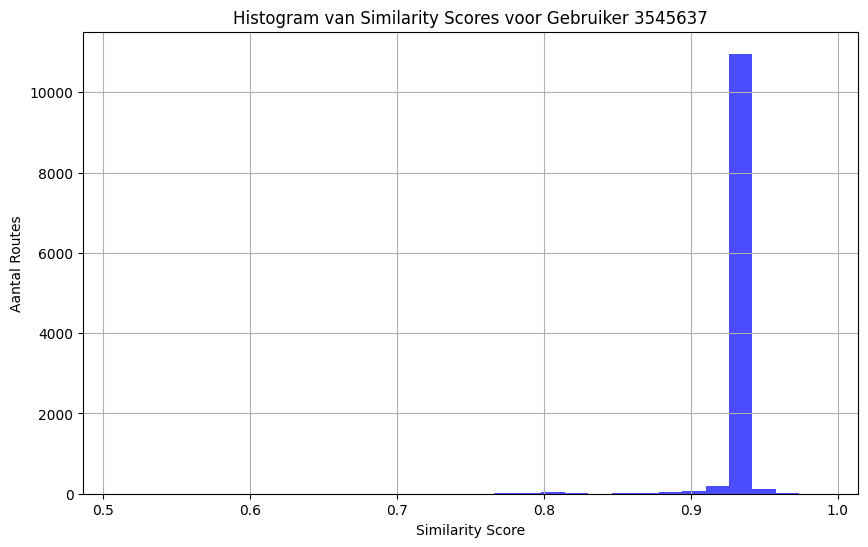

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,userId,average_condition_value,mean_altitude,mean_latitude,mean_longitude,distance_to_user,similarity_score
8753,"[55.693539110943675, 55.693539110943675, 55.69...","[12.497175307944417, 12.497175307944417, 12.49...","[17.0, 17.0, 17.0, 18.2, 18.6, 19.6, 21.0, 24....",run,379767081,"[58, 58, 59, 78, 83, 93, 99, 108, 111, 116, 11...","[1406424546, 1406424546, 1406424548, 140642455...","[3.1536, 3.1536, 5.2056, 8.6976, 9.2592, 8.920...",-0.253793,-0.392624,2083091,-1.246046,-0.423602,55.685378,12.482708,4.738130,0.990015
10282,"[55.70295634679496, 55.70296003483236, 55.7029...","[12.498838948085904, 12.498854538425803, 12.49...","[20.2, 20.4, 21.8, 21.8, 25.8, 25.8, 25.8, 25....",run,566137658,"[65, 65, 68, 72, 79, 85, 85, 85, 85, 88, 89, 8...","[1427117899, 1427117900, 1427117902, 142711790...","[1.5984, 1.9224, 2.2968, 2.2968, 5.382, 9.0576...",-0.637572,-0.542990,954504,-1.594697,-0.426368,55.711429,12.494706,6.955851,0.983815
6660,"[55.660312911495566, 55.66031509079039, 55.660...","[12.588416012004018, 12.588392039760947, 12.58...","[115.2, 115.2, 115.2, 114.0, 114.0, 114.0, 114...",run,303531332,"[74, 74, 76, 76, 79, 82, 86, 85, 85, 88, 90, 9...","[1393898827, 1393898828, 1393898833, 139389883...","[5.3028, 4.878, 7.8552, 8.046, 7.9272, 9.27, 8...",-1.044902,-0.701557,4434,-1.459061,-0.116257,55.651253,12.581523,10.800988,0.966088
6659,"[55.66028139553964, 55.66027795895934, 55.6602...","[12.588102528825402, 12.588072940707207, 12.58...","[0.0, 0.0, 0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0...",run,306205475,"[80, 80, 80, 83, 89, 89, 90, 102, 102, 118, 11...","[1394410691, 1394410692, 1394410697, 139441069...","[6.282, 6.1848, 7.902, 9.1908, 6.318, 8.9352, ...",-1.075705,-0.698823,4434,-1.459061,-0.485168,55.650191,12.580744,10.775737,0.965921
6661,"[55.749288741499186, 55.74929636903107, 55.749...","[12.293839054182172, 12.293819021433592, 12.29...","[13.2, 13.2, 13.2, 13.2, 13.0, 13.8, 14.6, 14....",run,253673046,"[66, 66, 67, 66, 66, 66, 71, 72, 72, 78, 78, 8...","[1380801876, 1380801877, 1380801881, 138080188...","[3.4452, 3.852, 10.0872, 11.0088, 11.538, 9.72...",-1.190027,-0.578530,4434,-1.459061,-0.453583,55.744968,12.303163,10.884309,0.965229
10681,"[55.750040765851736, 55.75004671700299, 55.750...","[12.583308247849345, 12.583295339718461, 12.58...","[8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 8.2, 9.2, 9.4, ...",run,262665677,"[144, 144, 147, 147, 147, 147, 147, 151, 151, ...","[1382814887, 1382814887, 1382814890, 138281489...","[8.0748, 7.9632, 7.578, 6.7788, 6.7968, 6.6564...",-1.115734,-0.354349,9198615,-1.627694,-0.420274,55.750295,12.579905,13.833156,0.963951
10685,"[55.75340467505157, 55.753405345603824, 55.753...","[12.587554352357984, 12.587532140314579, 12.58...","[22.2, 22.2, 22.2, 22.2, 22.2, 22.2, 22.2, 22....",run,382367664,"[125, 125, 131, 136, 137, 141, 142, 143, 145, ...","[1379269321, 1379269322, 1379269328, 137926933...","[2.9304, 3.1176, 4.4208, 5.1012, 5.2416, 5.284...",-1.116032,-0.450036,9198615,-1.627694,-0.418274,55.750394,12.583115,13.993940,0.963599
8749,"[55.65267423167825, 55.65266668796539, 55.6526...","[12.607328267768025, 12.607299350202084, 12.60...","[101.2, 63.4, 63.4, 63.4, 106.8, 105.6, 104.6,...",run,635188956,"[82, 82, 82, 82, 82, 87, 91, 100, 101, 109, 11...","[1447973675, 1447973676, 1447973677, 144797367...","[11.124, 11.124, 11.124, 11.124, 7.992, 9.036,...",-0.312293,-0.070022,1058434,-1.110381,-0.168392,55.652104,12.580451,10.717214,0.962289
8752,"[55.651613753288984, 55.65161065198481, 55.651...","[12.610173169523478, 12.610146012157202, 12.60...","[-52.8, -52.8, -49.4, 0.6, 0.8, 0.6, 0.6, 0.6,...",run,497266991,"[93, 92, 98, 103, 110, 115, 119, 127, 134, 139...","[1428244062, 1428244063, 1428244066, 142824406...","[28.2204, 28.5876, 31.41, 20.3832, 14.9256, 13...",0.002563,0.132288,1058434,-1.110381,-0.484401,55.654256,12.580280,10.665881,0.962084
8001,"[55.711693139746785, 55.71177704259753, 55.71

In [3]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
with open(user_profiles_path, 'r') as file:
    user_profiles_content = (json.loads(line) for line in file)
    user_profiles_df = pd.DataFrame(user_profiles_content)

with open(routes_path, 'r') as file:
    routes_content = [json.loads(line) for line in file if line.strip()]

routes_df = pd.DataFrame(routes_content)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = StandardScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=30):
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['average_distances']}<br>" \
                    f"Average Condition Value: {user_data['average_condition_value']}"

    map_obj = folium.Map(location=user_location, zoom_start=12)
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]  # Wijs een kleur toe aan elke route
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Average Altitude Change: {route_data['altitude_change']}<br>" \
                        f"Average Distance: {route_data['distance']}<br>" \
                        f"Average Condition Value: {route_data['average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj)  # Toon de kaart direct


    return recommended_routes


# Stap 6: Test de functie voor een specifieke gebruiker

sample_user_id = 3545637
# sample_user_id = 8899244
# sample_user_id = 3537163
# sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(30)


### ander manier inlezen bestanden

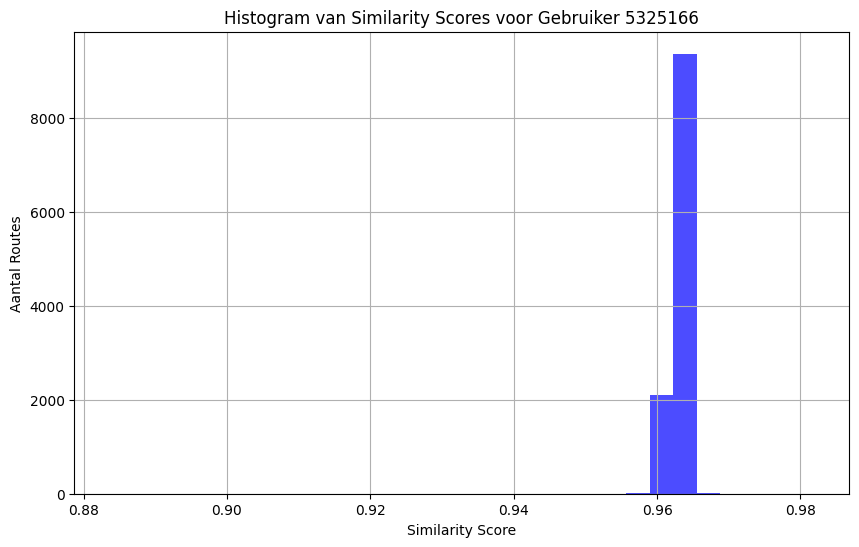

,latitude,longitude,altitude,sport,id,heart_rate,timestamp,speed,distance,altitude_change,userId,average_condition_value,mean_altitude,mean_latitude,mean_longitude,distance_to_user,similarity_score
4377,"[51.20322986505926, 51.20322617702186, 51.2032...","[3.243396375328302, 3.243342647328973, 3.24322...","[-64.8, -63.4, -1.4, -0.6000000000000001, -1.2...",run,496030702,"[78, 80, 84, 89, 96, 99, 102, 105, 107, 107, 1...","[1428017612, 1428017614, 1428017617, 142801762...","[2.3616, 3.1284, 5.1768, 8.6292, 11.466, 12.15...",-0.319249,0.156893,4006330,-0.926199,-0.481244,51.204403,3.243622,11.028653,0.981917
4378,"[51.20404617860913, 51.2040719948709, 51.20410...","[3.244259459897876, 3.24430220760405, 3.244401...","[37.0, 35.8, 34.8, 34.8, 34.8, 35.0, 35.0, 34....",run,437241451,"[88, 90, 93, 96, 99, 103, 105, 109, 110, 113, ...","[1415928232, 1415928234, 1415928237, 141592823...","[7.8012, 8.5968, 7.218, 7.7940000000000005, 8....",-0.486700,-0.696089,4006330,-0.926199,-0.367147,51.204400,3.243752,11.031345,0.980804
4376,"[51.20505167171359, 51.20507983490825, 51.2051...","[3.514015087857842, 3.514046687632799, 3.51417...","[10.4, 11.0, 11.6, 11.0, 11.0, 12.8, 11.8, 11....",run,559892591,"[89, 93, 98, 104, 107, 111, 118, 119, 121, 122...","[1436752545, 1436752548, 1436752551, 143675255...","[1.7027999999999999, 2.34, 5.22, 9.4356, 10.82...",-0.018748,-0.676951,4006330,-0.926199,-0.441008,51.221158,3.492178,24.348475,0.971895
8207,"[50.6844337284565, 50.6844337284565, 50.684430...","[3.139252569526434, 3.139256089925766, 3.13927...","[29.2, 29.2, 29.2, 30.0, 31.4, 32.6, 32.8, 33....",run,483910595,"[82, 82, 82, 86, 93, 98, 99, 103, 108, 113, 11...","[1410309683, 1410309683, 1410309684, 141030968...","[2.7576, 2.7936, 2.934, 5.1444, 7.6464, 8.8596...",-0.704532,-0.370753,4318337,-1.082564,-0.334308,50.688754,3.128357,47.165136,0.968802
8211,"[50.68452165462077, 50.68447194993496, 50.6844...","[3.139223149046302, 3.13931149430573, 3.139386...","[46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46.4, 46....",run,483910800,"[68, 74, 79, 85, 91, 97, 102, 105, 113, 112, 1...","[1407800221, 1407800225, 1407800227, 140780023...","[2.6172, 4.8852, 6.3216, 8.118, 9.5292, 10.926...",-0.566907,-0.419963,4318337,-1.082564,-0.322287,50.688988,3.128914,47.135545,0.968747
8214,"[50.68415377289057, 50.68415377289057, 50.6841...","[3.139372514560818, 3.139372514560818, 3.13939...","[37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 37.6, 38....",run,321488630,"[99, 99, 99, 101, 109, 112, 116, 122, 127, 132...","[1378561839, 1378561839, 1378561840, 137856184...","[9.8784, 7.8012, 6.0084, 5.9616, 7.02, 7.0632,...",-0.564346,-0.365285,4318337,-1.082564,-0.326658,50.688987,3.128770,47.136607,0.968743
8208,"[50.6849929690361, 50.684992130845785, 50.6849...","[3.139309147372842, 3.139311578124761, 3.13935...","[53.8, 53.8, 53.8, 52.8, 52.0, 51.4, 50.0, 48....",run,483910620,"[80, 80, 79, 85, 91, 96, 101, 109, 114, 119, 1...","[1409703126, 1409703126, 1409703128, 140970313...","[5.0544, 5.0544, 6.5988, 12.546, 13.608, 13.95...",-0.566330,-0.280533,4318337,-1.082564,-0.328292,50.689004,3.129106,47.132508,0.968739
8221,"[50.68454470485449, 50.68447873927653, 50.6844...","[3.139119632542133, 3.139265142381191, 3.13929...","[58.4, 58.4, 58.4, 58.2, 57.6, 57.0, 57.0, 56....",run,321490169,"[82, 88, 88, 96, 101, 111, 112, 119, 119, 122,...","[1366931099, 1366931104, 1366931105, 136693110...","[3.7836, 5.616, 6.2712, 9.1224, 10.5588, 10.05...",-0.562692,-0.250460,4318337,-1.082564,-0.325779,50.688938,3.128248,47.145475,0.968733
8218,"[50.684484019875526, 50.68447672761977, 50.684...","[3.13930420204997, 3.139313086867332, 3.139427...","[50.4, 50.4, 50.4, 50.4, 50.4, 50.4, 50.4, 50....",run,321489901,"[78, 77, 83, 88, 92, 99, 105, 110, 122, 122, 1...","[1368213466, 1368213466, 1368213472, 136821347...","[2.0448, 2.7648, 6.1812, 7.3944, 7.9524, 9.558...",-0.516164,-0.365285,4318337,-1.082564,-0.301848,50.688898,3.127913,47.152150,0.968718
8209,"[50.68501451052725, 50.68501476198435, 50.68

In [4]:
import pandas as pd
import numpy as np
import json
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from geopy.distance import geodesic
import folium
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Pad naar de bestanden
user_profiles_path = '../Data/Loopdata/kleinebestanden/run_gebruikersprofielen.json'
routes_path = '../Data/Loopdata/kleinebestanden/routes_volledig.json'

# Stap 1: Laad de gebruikersprofielen en routes
# with open(user_profiles_path, 'r') as file:
#     user_profiles_content = (json.loads(line) for line in file)
#     user_profiles_df = pd.DataFrame(user_profiles_content)

# with open(routes_path, 'r') as file:
#     routes_content = [json.loads(line) for line in file if line.strip()]

# routes_df = pd.DataFrame(routes_content)
user_profiles_df = pd.read_json(user_profiles_path, lines=True)
routes_df = pd.read_json(routes_path, lines=True)

# Stap 2: Preprocessing van de routegegevens
routes_df['mean_altitude'] = routes_df['altitude'].apply(np.mean)
routes_df['mean_latitude'] = routes_df['latitude'].apply(np.mean)
routes_df['mean_longitude'] = routes_df['longitude'].apply(np.mean)

# Voeg de meest voorkomende locatie van de gebruiker toe aan de DataFrame
user_profiles_df[['most_common_lat', 'most_common_lon']] = pd.DataFrame(user_profiles_df['average_location'].tolist(), index=user_profiles_df.index)

# Normaliseer de kenmerken behalve coördinaten met Min-Max schaling
scaler = StandardScaler()
user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']] = scaler.fit_transform(user_profiles_df[['average_speeds', 'average_altitude_changes', 'average_distances', 'average_condition_value']])
routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']] = scaler.fit_transform(routes_df[['altitude_change', 'distance', 'mean_altitude', 'average_condition_value']])

# Stap 3: Bepaal gewichten voor gebruikerskenmerken

gewichten = {}
for index, row in user_profiles_df.iterrows():
    user_id = row['userId']
    altitude_weight = row['weight_std_altitude_change']
    distance_weight = row['weight_std_distance']
    condition_weight = row['weight_std_condition_value']
    gewichten[user_id] = {
        'average_altitude_change': altitude_weight, 
        'average_distance': distance_weight, 
        'average_condition_value': condition_weight,
        'distance_to_user': 1.0}

# Stap 4: Definieer aanbevelingsfunctie voor routes

def recommend_routes_for_user_corrected(user_id, user_profiles_df, routes_df, top_n=30):
    user_data = user_profiles_df[user_profiles_df['userId'] == user_id]
    user_location = (user_data['most_common_lat'].iloc[0], user_data['most_common_lon'].iloc[0])


    # Bereken de afstand tussen de gebruiker en elke route
    def calculate_distance_to_user(row):
        route_location = (row['mean_latitude'], row['mean_longitude'])
        distance_to_user = geodesic(user_location, route_location).kilometers
        return distance_to_user

    routes_df['distance_to_user'] = routes_df.apply(calculate_distance_to_user, axis=1)

    # Functie om de cosine similarity te berekenen
    def calculate_cosine_similarity(row):
        user_values = user_data[['average_altitude_changes', 'average_distances', 'average_condition_value']].values[0]
        route_values = row[['altitude_change', 'distance', 'distance_to_user', 'average_condition_value']]

        # Bereken de gewogen waarden
        gewogen_user_values = np.array([
            user_values[0] * gewichten[user_id]['average_altitude_change'],
            user_values[1] * gewichten[user_id]['average_distance'],
            user_values[2] * gewichten[user_id]['average_condition_value'],
            gewichten[user_id]['distance_to_user']])

        gewogen_route_values = np.array([
            route_values['altitude_change'],
            route_values['distance'],
            route_values['average_condition_value'],
            route_values['distance_to_user']])

        # Cosine similarity berekenen
        return cosine_similarity([gewogen_user_values], [gewogen_route_values])[0][0]


    # Pas de cosine similarity functie toe en sla de score op
    routes_df['similarity_score'] = routes_df.apply(calculate_cosine_similarity, axis=1)
# Selecteer de routes met de hoogste cosine similarity scores
    recommended_routes = routes_df.sort_values(by='similarity_score', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.hist(routes_df['similarity_score'], bins=30, color='blue', alpha=0.7)
    plt.title(f'Histogram van Similarity Scores voor Gebruiker {user_id}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Aantal Routes')
    plt.grid(True)
    plt.show()
    # Stap 5: Creëer een kaart met de locatie van de gebruiker en de routes
    user_data = user_profiles_df[user_profiles_df['userId'] == sample_user_id].iloc[0]
    user_popup_info = f"UserID: {sample_user_id}<br>" \
                    f"Average Altitude Change: {user_data['average_altitude_changes']}<br>" \
                    f"Average Distance: {user_data['average_distances']}<br>" \
                    f"Average Condition Value: {user_data['average_condition_value']}"

    map_obj = folium.Map(location=user_location, zoom_start=12)
    folium.Marker(user_location, popup=user_popup_info).add_to(map_obj)

    # Definieer een lijst met kleuren
    colors = ["red", "blue", "green", "purple", "orange"]

    for index, route in enumerate(recommended_routes.iterrows()):
        _, route_data = route
        route_coords = list(zip(route_data['latitude'], route_data['longitude']))
        route_color = colors[index % len(colors)]  # Wijs een kleur toe aan elke route
        route_popup_info = f"Route ID: {route_data['id']}<br>" \
                        f"User ID: {route_data['userId']}<br>" \
                        f"Average Altitude Change: {route_data['altitude_change']}<br>" \
                        f"Average Distance: {route_data['distance']}<br>" \
                        f"Average Condition Value: {route_data['average_condition_value']}"
        folium.PolyLine(route_coords, color=route_color, weight=2.5, opacity=1, popup=route_popup_info).add_to(map_obj)

    display(map_obj)  # Toon de kaart direct


    return recommended_routes


# Stap 6: Test de functie voor een specifieke gebruiker

# sample_user_id = 1
# sample_user_id = 8899244
# sample_user_id = 3537163
sample_user_id = 5325166
recommended_routes = recommend_routes_for_user_corrected(sample_user_id, user_profiles_df, routes_df)

recommended_routes.head(10)
